In [1]:
from concurrent.futures import ProcessPoolExecutor, as_completed

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
cpu = 10

lgp_cutoff = 8
log2odds_cutoff = 1

## Load

### Pairwise Motif Enrichment

In [3]:
motif_enrichment_results = pd.read_msgpack('PairwiseMotifEnrichment.msg')
motif_enrichment_results['log2odds'] = np.log2(
    motif_enrichment_results['oddsratio'])
motif_enrichment_results = motif_enrichment_results[
    (motif_enrichment_results['-lgp'] > lgp_cutoff)
    & (motif_enrichment_results['log2odds'].abs() > log2odds_cutoff)].copy()

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [14]:
def judge_row(row):
    if row['log2odds'] < 0:
        return pd.Series({'enrich': row['ClusterB'], 'null': row['ClusterA']})
    else:
        return pd.Series({'enrich': row['ClusterA'], 'null': row['ClusterB']})


motif_sig_judge = motif_enrichment_results.apply(judge_row, axis=1)

In [15]:
motif_sig_judge['enrich'].unique()

array(['Gfra1_Gfra1', 'PT-L5_Ptprt', 'CA1_Kif26a', 'PT-L5_Astn2',
       'PT-L5_Plcb4', 'PT-L5_Kcnh1', 'PT-L5_Unc5b', 'PT-L5_Tmtc2',
       'PT-L5_Nectin1', 'NP-L6_Olfml2b', 'NP-L6_Cntnap4', 'NP-L6_Kcnab1',
       'CA1_Chrm3', 'PT-L5_Abca12', 'DG-po_Kctd8', 'DG-po_Calb2',
       'CA1_Ak5', 'NP-L6_Cntnap5a', 'NP-L6_Boc', 'CA3_Cadm2',
       'NP-L6_Cyp7b1', 'CA1_Lingo2', 'CA1_Ptprg', 'CA3-St18_Tead1',
       'L6b_Nrp2', 'CA3-St18_Nuak1', 'L6b_Pkhd1', 'L6b_Adcy8',
       'OLF-Exc_Rmst', 'CA3_Efnb2', 'CT-L6_Megf9', 'CA3-St18_Epha5',
       'IG-CA2_Chrm3', 'IG-CA2_Peak1', 'CT-L6_Il1rap', 'CT-L6_Map4',
       'DG_dg-all', 'L6b_Kcnk2', 'IG-CA2_Xpr1', 'DG-po_Bcl11a',
       'CT-L6_Hcrtr2', 'EP_Adcy8', 'OLF-Exc_Bmpr1b', 'EP_Tspan5',
       'OLF-Exc_Cdh9', 'EP_Rgs8', 'OLF-Exc_Cux2', 'OLF-Exc_Sgcd',
       'OLF-Exc_Pld5', 'CLA_Bcl11a', 'IT-L6_Cadps2', 'OLF-Exc_Lrrtm3',
       'CLA_Cdh8', 'CLA_Nrp2', 'OLF-Exc_Unc13c', 'IT-L6_Fstl4',
       'IT-L6_Man1c1', 'IT-L5_Etv1', 'IT-L6_Oxr1', 'IT-L5_Grik3',

In [11]:
motif_enrichment_results[
    motif_enrichment_results['ClusterA'].isin(['CA1_Chrm3', 'CA3_Cadm2'])
    & motif_enrichment_results['ClusterB'].isin(['CA1_Chrm3', 'CA3_Cadm2'
                                                 ])].loc['MA1109.1']

oddsratio           4.22987
p_value                   0
adj_p                     0
-lgp                    300
left_hit               8971
left_no_hit           60020
right_hit              3413
right_no_hit          96587
left_hit_rate      0.130031
right_hit_rate      0.03413
ClusterA          CA1_Chrm3
ClusterB          CA3_Cadm2
log2odds            2.08061
Name: MA1109.1, dtype: object

In [13]:
motif_sig_judge[
    motif_sig_judge['enrich'].isin(['CA1_Chrm3', 'CA3_Cadm2'])
    & motif_sig_judge['null'].isin(['CA1_Chrm3', 'CA3_Cadm2'])].loc['MA1109.1']

enrich    CA1_Chrm3
null      CA3_Cadm2
Name: MA1109.1, dtype: object

### Dendrogram

In [7]:
node_cluster_dict = joblib.load(
    '/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/RTree/Exc.non_singleton_node_dict.lib'
)

In [8]:
node_possible_count = {}
for node, sub_dict in node_cluster_dict.items():
    possible_pairs = len(sub_dict['left']) * len(sub_dict['right'])
    node_possible_count[node] = possible_pairs
node_possible_count = pd.Series(node_possible_count)

### Gene Meta

In [9]:
gene_meta = pd.read_csv(
    '/home/hanliu/ref/mouse/gencode/vm22/gencode.vM22.annotation.gene.flat.tsv.gz',
    sep='\t',
    index_col='gene_id')
gene_name_to_id = {v: k for k, v in gene_meta['gene_name'].items()}

## Assign motif to tree

In [33]:
def calculate_node_portion(sub_df):
    nodes_records = {}
    for k, v in node_cluster_dict.items():
        left = [i.replace(' ', '_') for i in v['left']]
        right = [i.replace(' ', '_') for i in v['right']]

        # left enrich, right null
        judge_from_left = sub_df['enrich'].apply(lambda i: i in left)
        judge_to_right = sub_df['null'].apply(lambda i: i in right)

        # right enrich, left hyper
        judge_from_right = sub_df['enrich'].apply(lambda i: i in right)
        judge_to_left = sub_df['null'].apply(lambda i: i in left)

        # this two cancel each other, use the remaining abs as real hits
        # positive means left hypo, negative means right hypo
        total = (judge_from_left & judge_to_right).sum() -\
                (judge_from_right & judge_to_left).sum()
        nodes_records[k] = total
    nodes_records = pd.Series(nodes_records) / node_possible_count
    return nodes_records

In [38]:
total_result = {}
with ProcessPoolExecutor(cpu) as executor:
    futures = {}
    for motif, sub_df in motif_sig_judge.groupby(motif_sig_judge.index):
        future = executor.submit(calculate_node_portion, sub_df)
        futures[future] = motif
        
    for future in as_completed(futures):
        result = future.result()
        gene = futures[future]
        total_result[gene] = result
total_result = pd.DataFrame(total_result)

In [42]:
mask_cutoff = 0.3

masked_result = total_result.copy()
masked_result[masked_result.abs() < 0.3] = 0

In [43]:
# gene that assign to at least one node
((masked_result != 0).sum(axis=0) != 0).sum()

376

In [44]:
# node that has at least 5 genes
((masked_result != 0).sum(axis=1) > 5).sum()

66

In [46]:
masked_result.apply(lambda i: 0 if i.abs().max() == 0 else i.abs().idxmax(), axis=0)

MA0014.3      0
MA0003.4     75
MA0018.4     90
MA0017.2    120
MA0007.3      0
           ... 
MA1648.1     72
MA1642.1     71
MA1655.1      0
MA1651.1      0
MA1683.1     70
Length: 497, dtype: int64

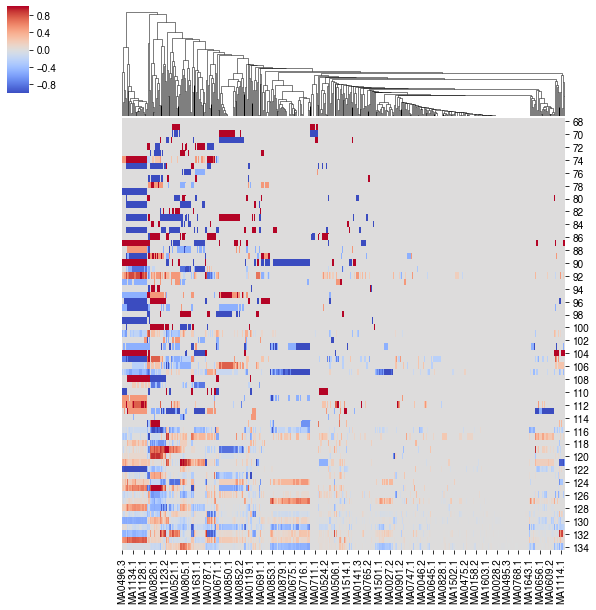

In [47]:
sns.clustermap(total_result, row_cluster=False, cmap='coolwarm')

In [48]:
total_result.to_msgpack('NodeMotifResults.msg')

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  """Entry point for launching an IPython kernel.
